# Demo3 of CubeNet
Usage of data resampling in CubeNet

In [1]:
import sys; sys.path.append('../../'); # To import CubeNet
import CubeNet

import numpy as np
import matplotlib.pyplot as plt

## Step 1: Load Seismograms and Stations

In [3]:
# Load Prepared waveform file
data_dict = np.load('data.npz');
data = data_dict['waveform'];
print('Shape of data (TraceID * Components * Sampling pts) :',data.shape);

Shape of data (TraceID * Components * Sampling pts) : (75, 3, 6000)


In [4]:
fs = data_dict['fs'];
print('Sampling rate of data:',fs,'Hz');

Sampling rate of data: 100 Hz


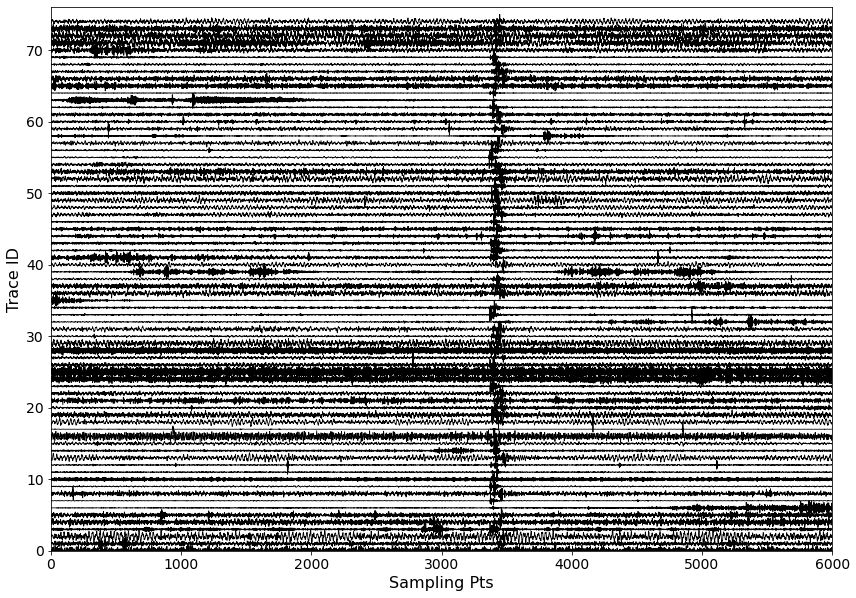

In [5]:
# Look at seismograms (Z component)
plt.figure(figsize=(14,10))
counter = 0;
for i in range(data.shape[0]):
    plt.plot(counter + data[i,2,:]/(max(data[i,2,:]) + 1e-12) , 'k' ,lw=0.8);
    counter += 1;
plt.xlim([0,data.shape[-1]]);plt.xticks(fontsize=14);plt.xlabel('Sampling Pts',fontsize=16);
plt.ylim([0,data.shape[0]+1]);plt.yticks(fontsize=14);plt.ylabel('Trace ID',fontsize=16);

In [6]:
# Load Prepared station file
sta = data_dict['sta']; # ATTENTION: unit is km
print('Shape of station array (TraceID * X/Y) :',sta.shape);

Shape of station array (TraceID * X/Y) : (75, 2)


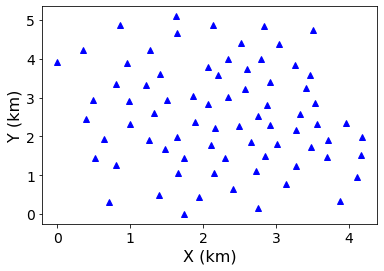

In [7]:
# Look at station corrdinates
plt.plot(sta[:,0],sta[:,1],'^b');
plt.xticks(fontsize=14); plt.yticks(fontsize=14);
plt.xlabel('X (km)',fontsize=16); plt.ylabel('Y (km)',fontsize=16);

## Step 2: Predict without resampling

In [9]:
# Using CubeNet to predict seismic phases
picker = CubeNet.picker;
picker.RegCube(sta)
_,pick_result,_ = picker.pick(data);
print('Shape of picking result (TraceID * P/S/Noi Probs * Sampling pts) :',pick_result.shape);

Shape of picking result (TraceID * P/S/Noi Probs * Sampling pts) : (75, 3, 6000)


In [10]:
# Create a funtion to plot the picking results

def wavenorm(data,scale=1):
    _range = np.max(data) - np.min(data);
    if _range != 0:
        return scale*(2*((data - np.min(data)) / _range)-1);
    if _range == 0:
        return np.zeros(data.shape);
    
def pickplot1D(Data,P_result,S_result,pick_num,plot_comp='Z',threshold=0.3):
    if plot_comp == 'X':
        plot_data = wavenorm(Data[pick_num,0,:],scale=0.8);
    elif plot_comp == 'Y':
        plot_data = wavenorm(Data[pick_num,1,:],scale=0.8);
    else:
        plot_data = wavenorm(Data[pick_num,2,:],scale=0.8);
        
    if np.max(P_result[pick_num,:]) > threshold:
        P_picks = np.argmax(P_result[pick_num,:]);
    else:
        P_picks = None;
        
    if np.max(S_result[pick_num,:]) > threshold:
        S_picks = np.argmax(S_result[pick_num,:]);
    else:
        S_picks = None;
    
    plt.figure(figsize=(18,6))
    plt.subplot(3,1,1);
    plt.plot(plot_data,'k',linewidth=0.8);
    if P_picks:
        plt.plot([P_picks,P_picks],[-1,1],'r--');
    if S_picks:
        plt.plot([S_picks,S_picks],[-1,1],'b--');
    plt.xticks([]);plt.yticks(fontsize=14);
    plt.subplot(3,1,2);
    plt.plot(P_result[pick_num,:],'r--',linewidth=0.8);
    plt.xticks([]);plt.yticks(fontsize=14);
    plt.ylim([-.1,1]);
    plt.subplot(3,1,3);
    plt.plot(S_result[pick_num,:],'b--',linewidth=0.8);
    plt.ylim([-.1,1]);
    plt.xticks(fontsize=14);plt.yticks(fontsize=14);
    plt.xlabel('Sampling Points',fontsize=18);
    
def pickplot2D(Data,P_result,S_result,plot_comp='Z',threshold=0.3):
    plt.figure(figsize=(16,10));
    tick_len = 0.8; tick_w = 1.4;
    counter = 0;
    for i in range(len(Data)):
        if plot_comp == 'X':
            plot_data = wavenorm(Data[i,0,:],scale=0.8);
        elif plot_comp == 'Y':
            plot_data = wavenorm(Data[i,1,:],scale=0.8);
        else:
            plot_data = wavenorm(Data[i,2,:],scale=0.8);
        plot_data = plot_data - np.average(plot_data);
        plt.plot(plot_data+counter,'k',linewidth=0.7);
        P_picks = np.argmax(P_result[i,:]); S_picks = np.argmax(S_result[i,:]);
        if P_result[i,P_picks] > threshold:
            plt.plot([P_picks,P_picks],[-tick_len+counter,tick_len+counter],'r',linewidth=tick_w);
        if S_result[i,S_picks] > threshold:
            plt.plot([S_picks,S_picks],[-tick_len+counter,tick_len+counter],'b',linewidth=tick_w);
        counter += 1;
    plt.xticks(fontsize=14);plt.yticks(fontsize=14);
    plt.ylim([-0.5,len(Data)+0.5]); plt.xlim([0,Data.shape[-1]]);
    plt.xlabel('Sampling Points',fontsize=18);
    plt.ylabel('Trace ID',fontsize=18);

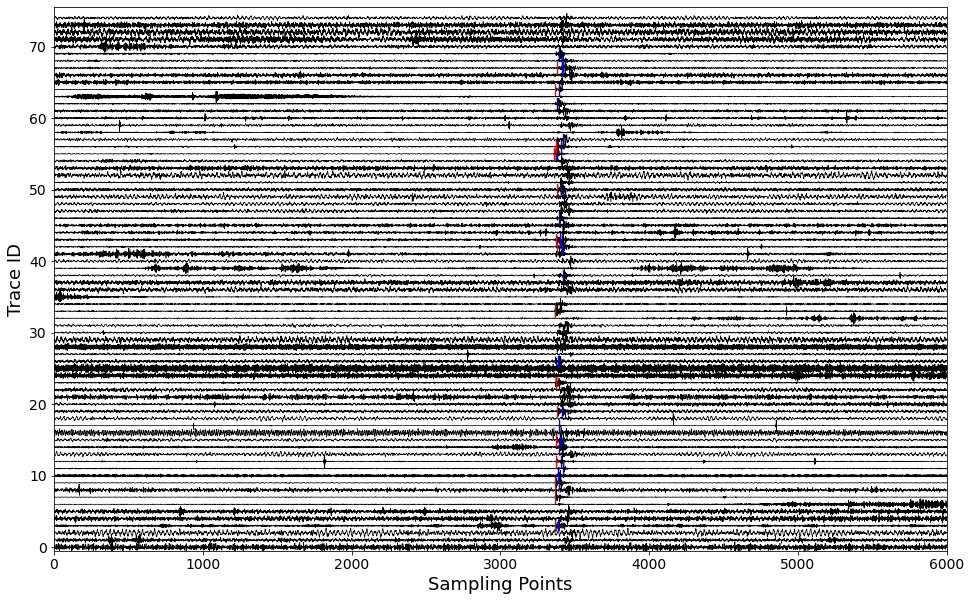

In [11]:
P_result = pick_result[:,0,:]; S_result = pick_result[:,1,:];
pickplot2D(data,P_result,S_result,plot_comp='Z');

## Step 3: Predict after resampling

In [ ]:
Resampled_data,pick_result,fs_new = picker.pick(data,data_fs=fs,Resample_Mode=True);

Sampling rate has been adjusted to 300 Hz!


In [12]:
print('New sampling rate:',fs_new,'Hz')

New sampling rate: 300 Hz


In [13]:
print('Shape of resampled data:',Resampled_data.shape)

Shape of resampled data: (75, 3, 18000)


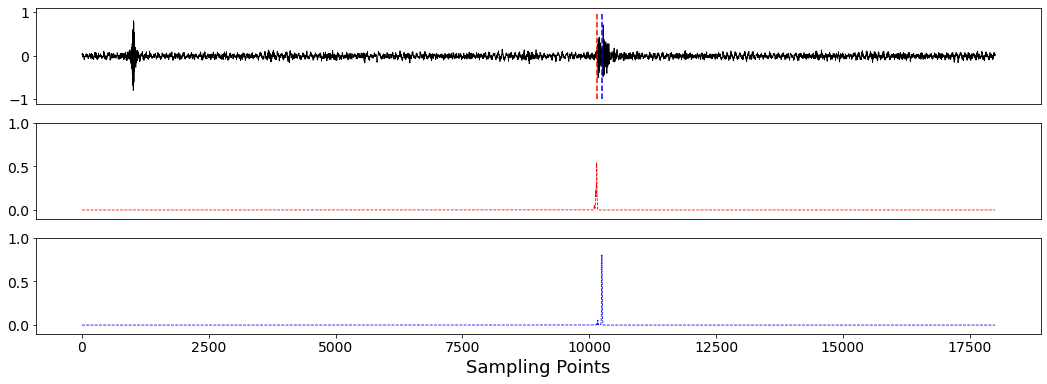

In [14]:
# plot picking result of different traces
chose_TraceID = 30;
P_result = pick_result[:,0,:]; S_result = pick_result[:,1,:];
pickplot1D(Resampled_data,P_result,S_result,chose_TraceID,plot_comp='X');

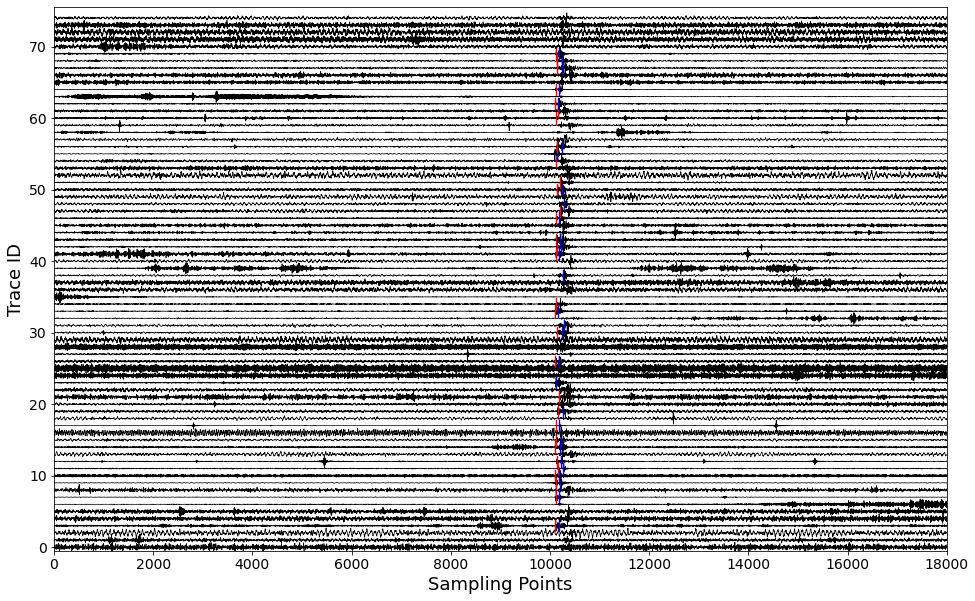

In [15]:
pickplot2D(Resampled_data,P_result,S_result,plot_comp='Z');